# Summary 3/19/20
This is a short walk-through of our current fast implementation of the btg program emphasizing workflow and data-analysis.

As of 3/19, the code adheres to most of the points outlined in the Latex BTG document started by Eric. Namely, it
- supports covariates
- stably computes weights $w(\theta_i, \lambda_j) \propto |\Sigma_\theta|^{-1/2} \tilde{q}^{-\frac{n-p}{2}} \text{jac}(z)$ by working with exponents 
- uses a quadrature rule on $\theta$ and $\lambda$
- Normalizes weights to get proper distribution: $ w(\theta_i, \lambda_j) = \frac{w(\theta_i) w(\lambda_j) p(y | \theta_i, \lambda_j)}
                                    {\sum_{i,j} w(\theta_i) w(\lambda_j) p(y | \theta_i, \lambda_j)}$
- takes advantage of built-in Julia T-dist CDF and PDF functions to compute Bayesian predictive PDF and CDF 
- includes documentation for each function
- stores and updates set of Cholesky factorizations

In addition it also 
- supports both Gaussian and Gauss-Turan quadrature for $\theta$ 
- includes derivatives for $\frac{\partial}{\partial z_{0}}\phi(z_0|z)$ for faster root finding and $\frac{\partial}{\partial s} \Phi(z_0|z;s)$ for solving the LCB-BO optimization problem, where $\Phi$ and $\phi$ are the CDF and PDFs of the Bayesian predictive distribution.
- uses bisection to find symmetric 95% credible interval about the median with Golden section search 
- doesn't suffer from improperness of distribution. It seems like CDF is always $\approx 1$ at sufficiently large number



### TODO: 
- Solve optimization problem for LCB-BO to determine next sampling point
       
$$\text{min}_u \;\text{s.t.}\;G(u;s)=0.25$$
by considering Lagrangian
$$\mathcal{L}(u, \lambda) = u+\lambda[G(u;s)-0.25]$$

- Apply Gaussian process regression on datasets (creep, abalone, ailerons) + comparison with warped GP
- Finish confidence-interval/mean/median-finding codes, possibly accelerate with derivatives
- Monte-Carlo quadrature for really high dimensions??
- Integrate sparsegrids.jl into package to do higher dimensional quadrature
- Scaling issues



## 1) Problem Setup

In [101]:
include("startup.jl")

ErrorException: could not open file C:\Users\Albert Huang\Desktop\btg\BayesTransformedGaussian\examples\startup.jl

In [102]:
include("../src/model.jl")
include("../src/transforms.jl")
include("../src/tools/plotting.jl")
include("../src/validation/validate.jl")
using DataFrames
using CSV
using Plots

Next we load the Abalone dataset, take a subset, and split it into train and test sets. We preprocess the dataset by squashing the data labels into the range $[0, 1]$. 

As per conventions in the paper, $s$ is the observation locations, $s_0$ is the prediction location, $X$ is the matrix of covariates for observed locations (where value/label is known), $X_0$ is matrix of covariates for prediction locations, and $z$ is vector of values/labels corresponding to observed locations $s$.  

In [103]:
df = DataFrame(CSV.File("../src/datasets/abalone.csv"))
data = convert(Matrix, df[:,2:8]) #length, diameter, height, whole weight, shucked weight, viscera weight, shell weight
target = convert(Array, df[:, 9]) #age
target = target/maximum(target) #normalization 

#pick training points
ind = 1:30
s = data[ind, :]

#choose a subset of variables to be regressors for the mean
X = data[ind, 1:3] 
z = float(target[ind])

#prior marginals are assumed constant for now
pλ = x -> 1  #p(λ)
pθ = x -> 1 #p(θ)
dpθ = x -> 0 #p'(λ)
dpθ2 = x -> 0 #p'(θ)

#define ranges for theta and lambda, which we will be integrating over
range_theta = [10.0, 100.0]
range_lambda = [-1.0, 1.0]

i = 240 #random index, where we will make prediction
s0 = data[i:i,:] #covariates and coordinates
X0  = data[i:i, 1:3]

train = trainingData(s, X, z) #a trainingData object contains s, X, and z
test = testingData(s0, X0) #a testingData object is missing z_0, the latent values at locations s_0

testingData{Array{Float64,2}}([0.565 0.425 … 0.2185 0.275], [0.565 0.425 0.16])

## 2) Computing the Bayesian Predictive Distribution
The cumulative and probability density functions for the $240$th data-point, conditioned on $30$ observed datapoints, are plotted below. Both Gauss quadrature and Turan quadrature use $12$ quadrature nodes. The plots are essentially indistinguishable from each other, perhaps because the problem size is small.


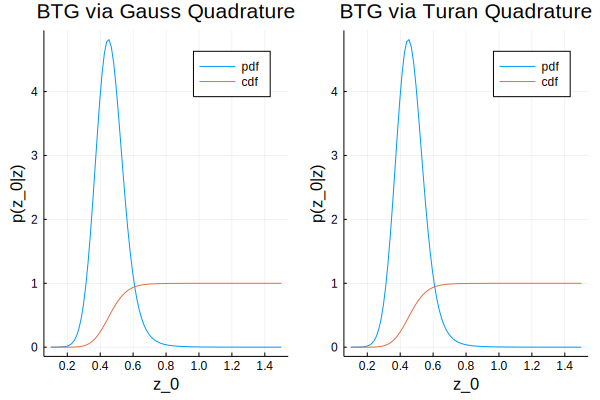

In [104]:
(f, g) = getBtgDensity(train, test, range_theta, range_lambda, boxCoxObj, "Gaussian", "Uniform")
(xG, yG) = plt_data(f, 0.1, 1.5, 100) 
(aG, bG) = plt_data(g, 0.1, 1.5, 100)
Xs = hcat(xG, aG); Ys = hcat(yG, bG)
plt1 = plot(Xs, Ys, labels = ["pdf" "cdf"], title = "BTG via Gauss Quadrature", xlabel = "z_0", ylabel = "p(z_0|z)")

(f1, g1) = getBtgDensity(train, test, range_theta, range_lambda, boxCoxObj, "Turan", "Uniform")
(xT, yT) = plt_data(f1, 0.1, 1.5, 100) 
(aT, bT) = plt_data(g1, 0.1, 1.5, 100)
Xs1 = hcat(xT, aT); Ys1 = hcat(yT, bT)
plt2 = plot(Xs1, Ys1, labels = ["pdf" "cdf"], title = "BTG via Turan Quadrature", xlabel = "z_0", ylabel = "p(z_0|z)")

plot(plt1, plt2, layout = 2) 

## 3) Cross-Validation
In this section we do delete-one cross validation on the first thirty datapoints in the Abalone dataset. It remains to compute MSE and other loss metrics.

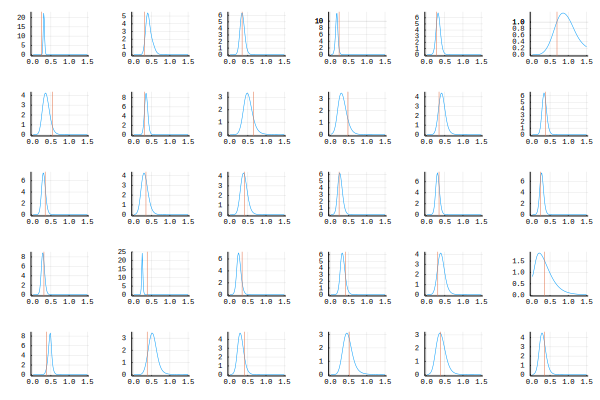

In [105]:
Xs, Ys = cross_validate(train, range_theta, range_lambda, boxCoxObj, "Gaussian", "Uniform")  
z = train.z
plt1 = plot(Xs, Ys, 
layout = length(z), 
legend=nothing, 
xtickfont = Plots.font(4, "Courier"),
ytickfont = Plots.font(4, "Courier"), 
lw=0.5)

plot!(z', layout = length(z), 
legend=nothing, 
seriestype = :vline, 
xtickfont = Plots.font(4, "Courier"), 
ytickfont = Plots.font(4, "Courier"), 
lw=0.5)